## Loading and preprocessing data

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, fbeta_score, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline

### Trim down to 1-day ahead and delete NAs

In [2]:
full_data = pd.read_csv("../data/processed/full_all_day_ahead.csv")
full_data.head()

cols_1_day_ahead = [c for c in full_data.columns if c == "Abnormal" or c.endswith("_1")]
data_1da = full_data[cols_1_day_ahead]

data_1da[data_1da.isna().any(axis=1)]

,ACWO_1,ADMO_1,ADRR_1,CSO_1,DPB_1,DPH_1,HTB_1,HTH_1,ITP_1,OGO_1,PPL_1,PS_1,RRIR_1,RRR_1,RR_1,TAGI_1,TGA_1,TLRR_1,Abnormal
2450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [3]:
data_1da = data_1da.dropna()
X_1da = data_1da.drop(columns="Abnormal")
y_1da = data_1da["Abnormal"]

In [4]:
X_1da.describe()

,ACWO_1,ADMO_1,ADRR_1,CSO_1,DPB_1,DPH_1,HTB_1,HTH_1,ITP_1,OGO_1,PPL_1,PS_1,RRIR_1,RRR_1,RR_1,TAGI_1,TGA_1,TLRR_1
count,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.0,2555.000000,2555.000000,2555.000000
mean,87.317025,1551.774951,333.169472,29773.672016,42.954599,41.488454,59.217221,60.987476,3053.151076,4343.996086,15997.675147,11479.643053,2469.966732,166.966732,2303.0,29947.284932,26894.133855,18467.641879
std,402.316988,629.205636,104.812077,1095.186472,17.641260,18.485792,17.153100,18.756608,421.240507,2723.465250,2442.056737,2877.171356,9.530731,9.530731,0.0,3016.025569,2907.177867,2443.259225
min,0.000000,1.000000,145.000000,27794.000000,-10.000000,-15.000000,8.000000,6.000000,938.000000,554.000000,11460.000000,2996.000000,2463.000000,160.000000,2303.0,19945.000000,16520.000000,13923.000000
25%,0.000000,1074.000000,244.000000,28841.000000,30.000000,28.000000,45.000000,44.000000,2888.000000,2153.000000,14200.000000,9549.000000,2463.000000,160.000000,2303.0,28153.500000,25196.000000,16673.000000
50%,0.000000,1476.000000,328.000000,29923.000000,44.000000,43.000000,59.000000,61.000000,3095.000000,3396.000000,15670.000000,11725.000000,2463.000000,160.000000,2303.0,30715.000000,27602.000000,18133.000000
75%,0.000000,1918.000000,422.000000,30501.000000,57.000000,57.000000,74.000000,77.000000,3295.000000,6284.000000,17200.000000,13694.500000,2483.000000,180.000000,2303.0,32213.000000,29043.000000,19683.000000
max,4864.000000,3813.000000,784.000000,31711.000000,74.000000,75.000000,97.000000,100.000000,4025.000000,12719.000000,26000.000000,18398.000000,2483.000000,180.000000,2303.0,35629.000000,32334.000000,28463.000000


In [5]:
## RR_1 appears to always have same value
X_1da["RR_1"].unique()
X_1da = X_1da.drop(columns="RR_1")

### Correlation

In [6]:
X_corr = X_1da.corr()
X_corr = X_corr.where(np.triu(np.ones(X_corr.shape), k=1).astype(bool))
X_corr = X_corr.unstack().dropna()
X_corr = abs(X_corr).sort_values(ascending=False)
print(X_corr[X_corr > 0.6])

RRR_1   RRIR_1    1.000000
TLRR_1  PPL_1     0.999993
TGA_1   TAGI_1    0.990557
DPH_1   DPB_1     0.978908
HTH_1   HTB_1     0.978224
TGA_1   OGO_1     0.918151
TAGI_1  OGO_1     0.914378
HTB_1   DPB_1     0.892576
        DPH_1     0.884908
HTH_1   DPB_1     0.873904
        DPH_1     0.868141
RRIR_1  HTH_1     0.752835
RRR_1   HTH_1     0.752835
RRIR_1  HTB_1     0.712488
RRR_1   HTB_1     0.712488
TGA_1   PS_1      0.666194
TAGI_1  PS_1      0.657151
RRR_1   DPB_1     0.609602
RRIR_1  DPB_1     0.609602
dtype: float64


### Scale and Encode

In [7]:
scaler = StandardScaler()
encoder = LabelEncoder()

X_norm = scaler.fit_transform(X_1da)
y_bin = encoder.fit_transform(y_1da)

### PCA

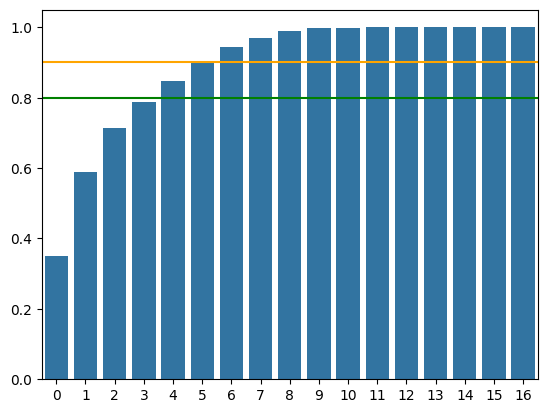

In [8]:
pca = PCA()
X_pc = pca.fit_transform(X_norm)

ax = sns.barplot(pca.explained_variance_ratio_.cumsum())
ax.axhline(y=0.9, color="orange")
ax.axhline(y=0.8, color="green")

In [9]:
pca.explained_variance_ratio_[:6].cumsum()

array([0.3508829 , 0.58987084, 0.7135205 , 0.78715864, 0.84691226,
       0.89874906])

In [10]:
## Take first 6 PCS, accounting for 90% variance
X_pcs = X_norm[:,:6]
X_pcs[:5]

array([[-0.21707788,  0.59964322, -1.79565477,  0.46332502, -0.96126452,
        -0.94623358],
       [-0.21707788,  0.87941575, -1.79565477,  0.46332502, -1.01796091,
        -0.94623358],
       [-0.21707788,  0.25310679, -1.79565477,  0.46332502,  0.00257408,
        -0.13464076],
       [-0.21707788,  0.807883  , -1.79565477,  0.46332502, -0.16751508,
        -0.24285314],
       [ 0.18069633,  0.42955424, -1.79565477,  0.46332502, -1.86840673,
        -1.81193259]])

## Baseline Model Building

### Data Splitting and Prep

In [11]:
# Test-train split
np.random.seed(7406)
X_train, X_test, y_train, y_test = train_test_split(X_1da, y_bin, train_size=0.7, stratify=y_bin)

smote = SMOTE(k_neighbors=10)
X_res, y_res = smote.fit_resample(X_train, y_train)
np.unique(y_res, return_counts=True)

(array([0, 1], dtype=int64), array([1764, 1764], dtype=int64))

In [12]:
print("Train mean(y) =", np.mean(y_train))
print("Resampled Train mean(y) =", np.mean(y_res))
print("Test mean(y) =", np.mean(y_test))

print("# pos in test set:", len(y_test[y_test == 1]))

Train mean(y) = 0.013422818791946308
Resampled Train mean(y) = 0.5
Test mean(y) = 0.014341590612777053
# pos in test set: 11


[0.35354057 0.59475076 0.7168968  0.78952061 0.85035354 0.90051941
 0.94369178 0.96970296 0.98836035 0.99767974 0.99894731 1.
 1.         1.         1.         1.         1.        ]


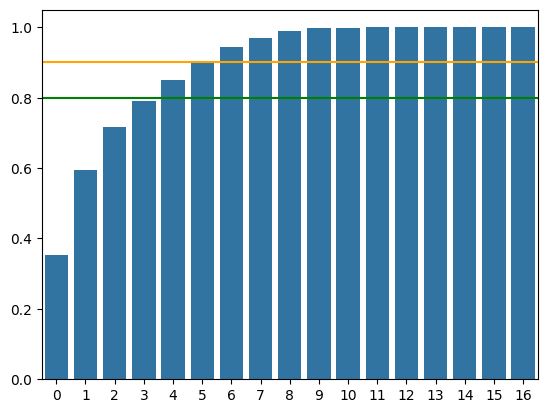

In [13]:
# Already encoded
# encoder = LabelEncoder()
# y_bin = encoder.fit_transform(y_1da)

scaler_tr = StandardScaler()
scaler_tr.fit(X_train)
X_tr_norm = scaler_tr.transform(X_train)

pca_tr = PCA()
pca_tr.fit(X_tr_norm)
X_tr_pc = pca.transform(X_tr_norm)

print(pca_tr.explained_variance_ratio_.cumsum())

ax = sns.barplot(pca_tr.explained_variance_ratio_.cumsum())
ax.axhline(y=0.9, color="orange")
ax.axhline(y=0.8, color="green")

[0.35354057 0.59475076 0.7168968  0.78952061 0.85035354 0.90051941
 0.94369178 0.96970296 0.98836035 0.99767974 0.99894731 1.
 1.         1.         1.         1.         1.        ]


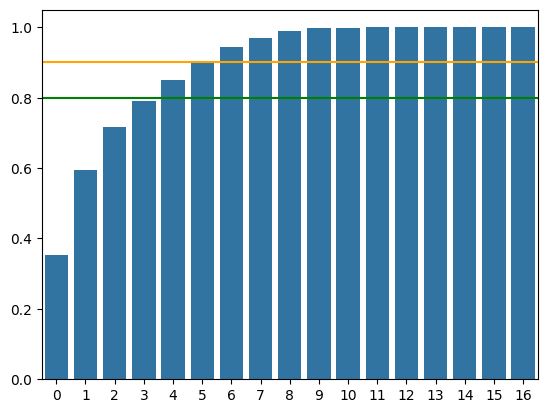

In [14]:
scaler_res = StandardScaler()
scaler_res.fit(X_train)
X_res_norm = scaler_tr.transform(X_res)

pca_res = PCA()
pca_res.fit(X_tr_norm)
X_res_pc = pca.transform(X_res_norm)

print(pca_res.explained_variance_ratio_.cumsum())

ax = sns.barplot(pca_res.explained_variance_ratio_.cumsum())
ax.axhline(y=0.9, color="orange")
ax.axhline(y=0.8, color="green")

### Pipelines and Training

Build combinations of:

1. Full or PCA feature set
2. SMOTE or Weighted models

Appropriate order:

1. Test-train split (already performed)
2. SMOTE
3. In each cross-validation:
   1. Normalize
   2. PCA (if performing)
   3. Fit model (with weights if not using SMOTE)

In [15]:
pipe_full_weighted = Pipeline([
  ("scale", StandardScaler()),
  ("rf", RandomForestClassifier(n_jobs=-1, class_weight="balanced"))
])

pipe_full_smote = Pipeline([
  ("scale", StandardScaler()),
  # ("smote", SMOTE(n_jobs=-1, k_neighbors=10)),
  ("rf", RandomForestClassifier(n_jobs=-1))
])

pipe_pca_weighted = Pipeline([
  ("scale", StandardScaler()),
  ("pca", PCA(n_components=6)),
  ("rf", RandomForestClassifier(n_jobs=-1, class_weight="balanced"))
])

pipe_pca_smote = Pipeline([
  ("scale", StandardScaler()),
  # ("smote", SMOTE(n_jobs=-1, k_neighbors=10)),
  ("pca", PCA(n_components=6)),
  ("rf", RandomForestClassifier(n_jobs=-1))
])

rf_params = {
    'rf__min_samples_split': [2, 5, 10],
    'rf__n_estimators': [100, 250, 500, 1000]
}

kf = StratifiedKFold(n_splits=10)
scorer = make_scorer(fbeta_score, beta=2)

In [16]:
search_full_weighted = GridSearchCV(pipe_full_weighted, rf_params, scoring=scorer, cv=kf, n_jobs=-1, refit=True)
search_full_weighted.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 250, 500, 1000]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [17]:
search_full_smote = GridSearchCV(pipe_full_smote, rf_params, scoring=scorer, cv=kf, n_jobs=-1, refit=True)
search_full_smote.fit(X_res, y_res)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 250, 500, 1000]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [18]:
search_pca_weighted = GridSearchCV(pipe_pca_weighted, rf_params, scoring=scorer, cv=kf, n_jobs=-1, refit=True)
search_pca_weighted.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('pca', PCA(n_components=6)),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 250, 500, 1000]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [19]:
search_pca_smote = GridSearchCV(pipe_pca_smote, rf_params, scoring=scorer, cv=kf, n_jobs=-1, refit=True)
search_pca_smote.fit(X_res, y_res)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('pca', PCA(n_components=6)),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 250, 500, 1000]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

#### Full-weighted

In [20]:
print("Full-weighted:")
print(search_full_weighted.best_params_)

y_pred_fw = search_full_weighted.predict(X_train)

print("Train F2:", fbeta_score(y_train, y_pred_fw, beta=2))
print(classification_report(y_train, y_pred_fw))

Full-weighted:
{'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Train F2: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1764
           1       1.00      1.00      1.00        24

    accuracy                           1.00      1788
   macro avg       1.00      1.00      1.00      1788
weighted avg       1.00      1.00      1.00      1788



Test F2: 0.0
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       756
           1       0.00      0.00      0.00        11

    accuracy                           0.99       767
   macro avg       0.49      0.50      0.50       767
weighted avg       0.97      0.99      0.98       767



c:\Users\willc\OneDrive\OMSA\03 SP24 ISYE7406 DMSL\Project\dmsl-project\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\willc\OneDrive\OMSA\03 SP24 ISYE7406 DMSL\Project\dmsl-project\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\willc\OneDrive\OMSA\03 SP24 ISYE7406 DMSL\Project\dmsl-project\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

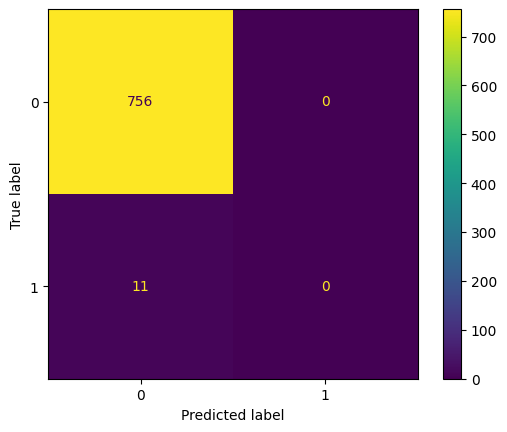

In [21]:
y_pred_fw = search_full_weighted.predict(X_test)

print("Test F2:", fbeta_score(y_test, y_pred_fw, beta=2))
print(classification_report(y_test, y_pred_fw))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_fw)

#### Full-SMOTE

In [22]:
print("Full-SMOTE:")
print(search_full_smote.best_params_)

y_pred_fs = search_full_smote.predict(X_res)

print("Train F2:", fbeta_score(y_res, y_pred_fs, beta=2))
print(classification_report(y_res, y_pred_fs))

Full-SMOTE:
{'rf__min_samples_split': 2, 'rf__n_estimators': 1000}
Train F2: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1764
           1       1.00      1.00      1.00      1764

    accuracy                           1.00      3528
   macro avg       1.00      1.00      1.00      3528
weighted avg       1.00      1.00      1.00      3528



Test F2: 0.18518518518518517
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       756
           1       0.20      0.18      0.19        11

    accuracy                           0.98       767
   macro avg       0.59      0.59      0.59       767
weighted avg       0.98      0.98      0.98       767



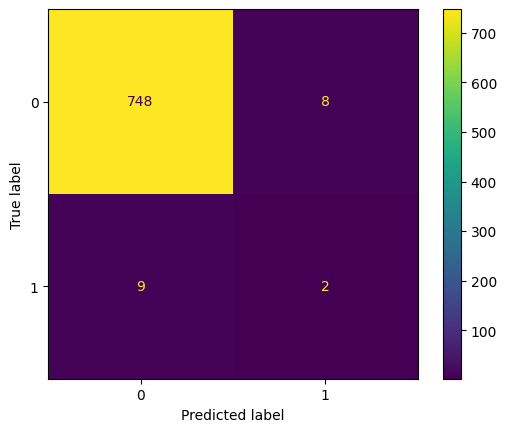

In [23]:
y_pred_fs = search_full_smote.predict(X_test)

print("Test F2:", fbeta_score(y_test, y_pred_fs, beta=2))
print(classification_report(y_test, y_pred_fs))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_fs)

#### PCA-weighted

In [24]:
print("PCA-weighted:")
print(search_pca_weighted.best_params_)

y_pred_pw = search_pca_weighted.predict(X_train)

print("Train F2:", fbeta_score(y_train, y_pred_pw, beta=2))
print(classification_report(y_train, y_pred_pw))

PCA-weighted:
{'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Train F2: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1764
           1       1.00      1.00      1.00        24

    accuracy                           1.00      1788
   macro avg       1.00      1.00      1.00      1788
weighted avg       1.00      1.00      1.00      1788



Test F2: 0.0
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       756
           1       0.00      0.00      0.00        11

    accuracy                           0.99       767
   macro avg       0.49      0.50      0.50       767
weighted avg       0.97      0.99      0.98       767



c:\Users\willc\OneDrive\OMSA\03 SP24 ISYE7406 DMSL\Project\dmsl-project\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\willc\OneDrive\OMSA\03 SP24 ISYE7406 DMSL\Project\dmsl-project\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\willc\OneDrive\OMSA\03 SP24 ISYE7406 DMSL\Project\dmsl-project\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

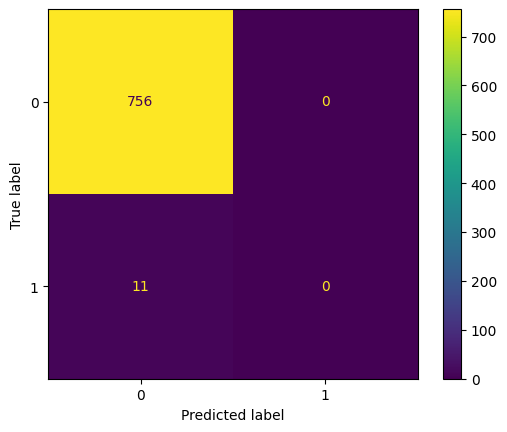

In [25]:
y_pred_pw = search_pca_weighted.predict(X_test)

print("Test F2:", fbeta_score(y_test, y_pred_pw, beta=2))
print(classification_report(y_test, y_pred_pw))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pw)

#### PCA-SMOTE

In [26]:
print("PCA-SMOTE:")
print(search_pca_smote.best_params_)

y_pred_ps = search_pca_smote.predict(X_res)

print("Test F2:", fbeta_score(y_res, y_pred_ps, beta=2))
print(classification_report(y_res, y_pred_ps))


PCA-SMOTE:
{'rf__min_samples_split': 2, 'rf__n_estimators': 1000}
Test F2: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1764
           1       1.00      1.00      1.00      1764

    accuracy                           1.00      3528
   macro avg       1.00      1.00      1.00      3528
weighted avg       1.00      1.00      1.00      3528



Test F2: 0.23148148148148148
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       756
           1       0.08      0.45      0.13        11

    accuracy                           0.92       767
   macro avg       0.53      0.69      0.54       767
weighted avg       0.98      0.92      0.94       767



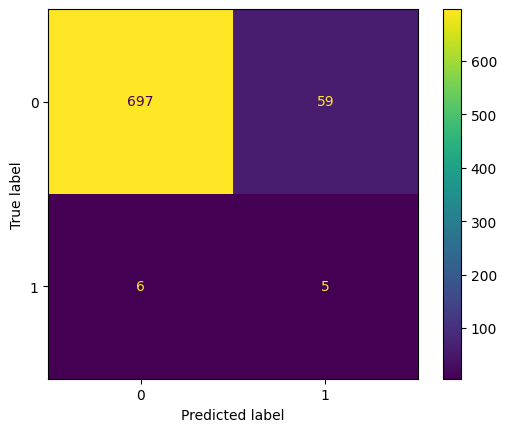

In [27]:
y_pred_ps = search_pca_smote.predict(X_test)

print("Test F2:", fbeta_score(y_test, y_pred_ps, beta=2))
print(classification_report(y_test, y_pred_ps))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ps)

In [31]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    search_full_smote, X_test, y_test, n_repeats=10, n_jobs=-1
)

forest_importances = pd.Series(result.importances_mean, index=X_1da.columns)
forest_importances

ACWO_1    0.014148
ADMO_1    0.019316
ADRR_1   -0.009647
CSO_1     0.038047
DPB_1     0.008198
DPH_1     0.051826
HTB_1     0.028850
HTH_1     0.033973
ITP_1     0.050209
OGO_1     0.067107
PPL_1     0.042265
PS_1      0.066895
RRIR_1    0.047207
RRR_1     0.047207
TAGI_1    0.057900
TGA_1     0.083920
TLRR_1    0.040281
dtype: float64

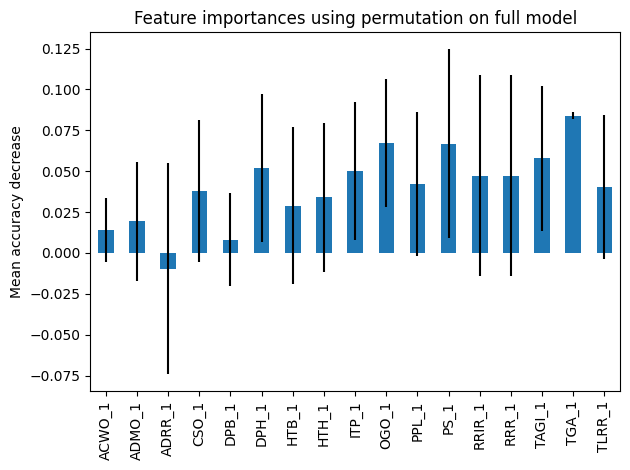

In [32]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()